In [1]:
print("✅ 라이브러리 로딩 시작...")
import joblib
import pandas as pd
import numpy as np
import time
import os
import warnings
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
print("✅ 라이브러리 로딩 완료!")

# =======================================================
# 🧹 1단계: 정제된 데이터 로딩
# =======================================================
print("\n" + "="*80)
print("🧹 1단계: 정제된 데이터 로딩")
print("="*80)
print("📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...")
try:
    flow_data = joblib.load("task2_data/train_flow_data_cleaned.pkl")
    all_packets = joblib.load("task2_data/train_packet_data_cleaned.pkl")
    print(f"✅ 정제된 Flow 데이터 ({len(flow_data):,}개) 로딩 완료")
    print(f"✅ 정제된 Packet 데이터 ({len(all_packets):,}개) 로딩 완료")
except FileNotFoundError:
    print("❌ 정제된 파일을 찾을 수 없습니다!")
    print("   먼저 이전 파이프라인의 '데이터 정제' 부분을 실행하여 _cleaned.pkl 파일을 생성해주세요.")
    exit()

✅ 라이브러리 로딩 시작...
✅ 라이브러리 로딩 완료!

🧹 1단계: 정제된 데이터 로딩
📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...
✅ 정제된 Flow 데이터 (381,559개) 로딩 완료
✅ 정제된 Packet 데이터 (381,559개) 로딩 완료


In [2]:
# =======================================================
# 🎯 2단계: 대표 샘플 생성 (전체 데이터 사용)
# =======================================================
print("\n" + "="*80)
print("🎯 2단계: 대표 샘플 생성 (전체 데이터 사용)")
print("="*80)

# 👈 전체 데이터 사용 → target_total_samples 대신 전체 길이
target_total_samples = len(flow_data)  
print(f"🎯 목표 총 샘플 수: {target_total_samples:,}개")

# 전체 인덱스를 그대로 사용
sampled_indices = np.arange(len(flow_data))

print(f"✅ 전체 데이터 사용 완료! 총 {len(sampled_indices):,}개 인덱스 확보.")



🎯 2단계: 대표 샘플 생성 (전체 데이터 사용)
🎯 목표 총 샘플 수: 381,559개
✅ 전체 데이터 사용 완료! 총 381,559개 인덱스 확보.


In [3]:
def extract_packet_features(packets, n=3):
    features = {}
    num_packets = min(n, len(packets))
    if num_packets == 0:
        return features
    packets = packets.iloc[:num_packets]
    
    numeric_cols = packets.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        features[f'first_{col}'] = packets.iloc[0][col] if col in packets.columns else 0
        features[f'second_{col}'] = packets.iloc[1][col] if col in packets.columns and num_packets > 1 else 0
    
    if 'ip_len' in packets.columns:
        ip_lens = packets['ip_len'].values
        features['ip_len_mean_13'] = np.mean(ip_lens)
        features['ip_len_std_13'] = np.std(ip_lens) if len(ip_lens) > 1 else 0
        features['ip_len_max_13'] = np.max(ip_lens)
        features['ip_len_min_13'] = np.min(ip_lens)
        features['ip_len_range_13'] = np.max(ip_lens) - np.min(ip_lens)
        features['ip_len_median_13'] = np.median(ip_lens)
        if len(ip_lens) >= 2:
            diffs = np.diff(ip_lens)
            mean_diff = np.mean(diffs)
            features['ip_len_trend'] = 1 if mean_diff > 0 else (-1 if mean_diff < 0 else 0)
            features['ip_len_volatility'] = np.std(diffs) if len(diffs) > 1 else 0
        else:
            features['ip_len_trend'] = 0
            features['ip_len_volatility'] = 0

    if 'packet_capture_time' in packets.columns and num_packets > 1:
        try:
            times = pd.to_datetime(packets['packet_capture_time'])
            time_diffs = np.diff(times).astype('timedelta64[us]').astype(float)
            if len(time_diffs) > 0:
                features['inter_time_mean_13'] = np.mean(time_diffs)
                features['inter_time_std_13'] = np.std(time_diffs) if len(time_diffs) > 1 else 0
                features['inter_time_max_13'] = np.max(time_diffs)
                features['inter_time_min_13'] = np.min(time_diffs)
                mean_time = np.mean(time_diffs)
                features['timing_consistency'] = np.std(time_diffs) / (mean_time + 1e-6)
            else:
                for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
                    features[key] = 0
        except:
            for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
                features[key] = 0
    else:
        for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
            features[key] = 0

    if 'tcp_len' in packets.columns and 'ip_len' in packets.columns:
        tcp_lens = packets['tcp_len'].values
        features['tcp_len_mean_13'] = np.mean(tcp_lens)
        features['tcp_len_std_13'] = np.std(tcp_lens) if len(tcp_lens) > 1 else 0
        features['tcp_len_sum_13'] = np.sum(tcp_lens)
        total_ip = np.sum(packets['ip_len'])
        total_tcp = np.sum(tcp_lens)
        features['tcp_efficiency_13'] = total_tcp / max(total_ip, 1)

    if 'tcp_flags' in packets.columns:
        flags = packets['tcp_flags'].values
        features['has_syn'] = int(any(flag & 0x02 for flag in flags))
        features['has_ack'] = int(any(flag & 0x10 for flag in flags))
        features['has_fin'] = int(any(flag & 0x01 for flag in flags))
        features['has_rst'] = int(any(flag & 0x04 for flag in flags))
        features['has_psh'] = int(any(flag & 0x08 for flag in flags))
        if len(flags) >= 3:
            first_syn = (flags[0] & 0x02) != 0
            second_syn_ack = (flags[1] & 0x12) == 0x12
            third_ack = (flags[2] & 0x10) != 0
            features['is_handshake_complete'] = int(first_syn and second_syn_ack and third_ack)
            has_fin_ack = any((flag & 0x11) == 0x11 for flag in flags)
            features['is_graceful_close'] = int(has_fin_ack)
        else:
            features['is_handshake_complete'] = 0
            features['is_graceful_close'] = 0
        features['flag_diversity'] = len(set(flags))
        features['push_frequency'] = sum(1 for flag in flags if flag & 0x08) / len(flags) if len(flags) > 0 else 0
    else:
        features['has_syn'] = 0
        features['has_ack'] = 0
        features['has_fin'] = 0
        features['has_rst'] = 0
        features['has_psh'] = 0
        features['is_handshake_complete'] = 0
        features['is_graceful_close'] = 0
        features['flag_diversity'] = 0
        features['push_frequency'] = 0

    if 'ip_len' in packets.columns and num_packets >= 3:
        sizes = packets['ip_len'].values
        increases = sum(1 for i in range(1, len(sizes)) if sizes[i] > sizes[i-1])
        decreases = sum(1 for i in range(1, len(sizes)) if sizes[i] < sizes[i-1])
        stability = sum(1 for i in range(1, len(sizes)) if sizes[i] == sizes[i-1])
        features['size_increase_count'] = increases
        features['size_decrease_count'] = decreases
        features['size_stability'] = stability
    else:
        features['size_increase_count'] = 0
        features['size_decrease_count'] = 0
        features['size_stability'] = 0

    if 'tcp_len' in packets.columns and 'ip_len' in packets.columns:
        features['tcp_to_ip_ratio_first'] = packets.iloc[0]['tcp_len'] / max(packets.iloc[0]['ip_len'], 1)
        if num_packets > 1:
            features['tcp_to_ip_ratio_second'] = packets.iloc[1]['tcp_len'] / max(packets.iloc[1]['ip_len'], 1)
        else:
            features['tcp_to_ip_ratio_second'] = 0
    else:
        features['tcp_to_ip_ratio_first'] = 0
        features['tcp_to_ip_ratio_second'] = 0

    features['inter_packet_time_us'] = features.get('inter_time_mean_13', 0)
    features['ip_len_diff'] = features.get('second_ip_len', 0) - features.get('first_ip_len', 0)

    return features


def extract_advanced_features_from_cleaned_data(indices, packet_data_list, n=3):
    print("🚀 고급 특징 추출 시작 (샘플링 데이터)...")
    features_list = []
    for i, idx in enumerate(indices):
        try:
            packet_df = packet_data_list[idx]
            if isinstance(packet_df, pd.DataFrame) and not packet_df.empty:
                valid_packets = packet_df.dropna()
                if len(valid_packets) >= 1:
                    features = extract_packet_features(valid_packets, n)
                    features_list.append(features)
                else:
                    features_list.append({})
            else:
                features_list.append({})
            if (i + 1) % 10000 == 0:
                print(f"     진행률: {i + 1:,} / {len(indices):,}개 완료")
        except Exception:
            features_list.append({})
    return features_list


advanced_features_list = extract_advanced_features_from_cleaned_data(sampled_indices, all_packets)
advanced_features_df = pd.DataFrame(advanced_features_list).fillna(0)
valid_flow_data = flow_data.iloc[sampled_indices].reset_index(drop=True)
print(f"\n✅ 특징 추출 완료! (샘플링 데이터)")
print(f"✓ 최종 특징 행렬 크기: {advanced_features_df.shape}")
print(f"✓ 최종 타겟 데이터 크기: {valid_flow_data.shape}")

🚀 고급 특징 추출 시작 (샘플링 데이터)...
     진행률: 10,000 / 381,559개 완료
     진행률: 20,000 / 381,559개 완료
     진행률: 30,000 / 381,559개 완료
     진행률: 40,000 / 381,559개 완료
     진행률: 50,000 / 381,559개 완료
     진행률: 60,000 / 381,559개 완료
     진행률: 70,000 / 381,559개 완료
     진행률: 80,000 / 381,559개 완료
     진행률: 90,000 / 381,559개 완료
     진행률: 100,000 / 381,559개 완료
     진행률: 110,000 / 381,559개 완료
     진행률: 120,000 / 381,559개 완료
     진행률: 130,000 / 381,559개 완료
     진행률: 140,000 / 381,559개 완료
     진행률: 150,000 / 381,559개 완료
     진행률: 160,000 / 381,559개 완료
     진행률: 170,000 / 381,559개 완료
     진행률: 180,000 / 381,559개 완료
     진행률: 190,000 / 381,559개 완료
     진행률: 200,000 / 381,559개 완료
     진행률: 210,000 / 381,559개 완료
     진행률: 220,000 / 381,559개 완료
     진행률: 230,000 / 381,559개 완료
     진행률: 240,000 / 381,559개 완료
     진행률: 250,000 / 381,559개 완료
     진행률: 260,000 / 381,559개 완료
     진행률: 270,000 / 381,559개 완료
     진행률: 280,000 / 381,559개 완료
     진행률: 290,000 / 381,559개 완료
     진행률: 300,000 / 381,559개 완료
     진행률: 310,000 / 38

In [4]:
X = advanced_features_df
y_duration = valid_flow_data['duration_class']

from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import joblib
import numpy as np

# 데이터 분할 (duration_class만 사용)
X_train, X_test, y_duration_train, y_duration_test = train_test_split(
    X, y_duration, test_size=0.2, random_state=42, stratify=y_duration
)

print(f"\n📊 데이터 준비: 학습 {X_train.shape[0]:,}개 | 검증 {X_test.shape[0]:,}개 | 특징 {X_train.shape[1]:,}개")

# 클래스 가중치 계산
duration_classes = np.unique(y_duration_train)
duration_weights = compute_class_weight('balanced', classes=duration_classes, y=y_duration_train)
duration_class_weights = {int(cls): weight for cls, weight in zip(duration_classes, duration_weights)}

# XGBoost 모델 학습 (GPU 0번, Optuna 튜닝 결과 반영)
xgb_best_params = {
    'n_estimators': 400,
    'max_depth': 10,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'tree_method': 'gpu_hist',  # GPU 사용
    'gpu_id': 0                 # GPU 0번 사용
}

xgb_duration = XGBClassifier(**xgb_best_params)

# 클래스 가중치를 sample_weight로 전달
sample_weight = y_duration_train.map(duration_class_weights)
xgb_duration.fit(X_train, y_duration_train, sample_weight=sample_weight)

# 모델 저장
joblib.dump(xgb_duration, 'model/xgb_duration_model_0809.pkl')
print('✅ XGBoost Duration 모델 저장 완료: model/xgb_duration_model_0809.pkl')



📊 데이터 준비: 학습 305,247개 | 검증 76,312개 | 특징 53개
✅ XGBoost Duration 모델 저장 완료: model/xgb_duration_model_0809.pkl


In [5]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# 예측
y_pred = xgb_duration.predict(X_test)

# 전체 Accuracy
accuracy = accuracy_score(y_duration_test, y_pred)

# 클래스별 Precision, Recall, F1
report = classification_report(y_duration_test, y_pred, digits=4)

print("\n📊 모델 성능 평가")
print(f"✅ Accuracy: {accuracy:.4f}")
print(report)

# 매크로 평균 점수 (클래스 불균형 영향 최소화)
f1_macro = f1_score(y_duration_test, y_pred, average='macro')
precision_macro = precision_score(y_duration_test, y_pred, average='macro')
recall_macro = recall_score(y_duration_test, y_pred, average='macro')

print("📈 매크로 평균 성능")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")



📊 모델 성능 평가
✅ Accuracy: 0.7545
              precision    recall  f1-score   support

           0     0.9017    0.9581    0.9290      2986
           1     0.8023    0.7832    0.7927     27053
           2     0.5861    0.7213    0.6467     17901
           3     0.8345    0.7265    0.7768     28372

    accuracy                         0.7545     76312
   macro avg     0.7812    0.7973    0.7863     76312
weighted avg     0.7675    0.7545    0.7579     76312

📈 매크로 평균 성능
F1 Score (Macro): 0.7863
Precision (Macro): 0.7812
Recall (Macro): 0.7973


### 이제 볼륨

✅ 라이브러리 로딩 시작...
✅ 라이브러리 로딩 완료!

🔧 1단계: 특징 추출 함수 정의
✅ 특징 추출 함수 준비 완료!

🔬 2단계: 최종 데이터 준비 (최대 N=3, 전체 데이터)
🚀 최대 N=3 값을 기준으로 전체 데이터에 대한 특징 추출 중...
✅ 특징 추출 완료! (소요 시간: 397.38초, 최종 샘플 수: 381,559개)
📊 데이터 분할 완료: 학습 305,247개 | 검증 76,312개

⏳ 클래스 가중치를 계산합니다...
✅ 계산된 가중치(dict): {0: np.float64(0.729076899559564), 1: np.float64(1.0311423243747213), 2: np.float64(0.7028223689663747), 3: np.float64(4.241426745220098)}

🏆 3단계: 랜덤 포레스트 모델 정의 및 학습
사용될 하이퍼파라미터: {'n_estimators': 855, 'max_depth': 22}

⏳ 모델 학습 시작...
✅ 학습 완료! (소요 시간: 42.01초)

📊 4단계: 최종 성능 평가

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     26167
           1       0.83      0.83      0.83     18502
           2       0.85      0.79      0.82     27145
           3       0.38      0.51      0.44      4498

    accuracy                           0.84     76312
   macro avg       0.75      0.77      0.76     76312
weighted avg       0.85      0.84      0.85   

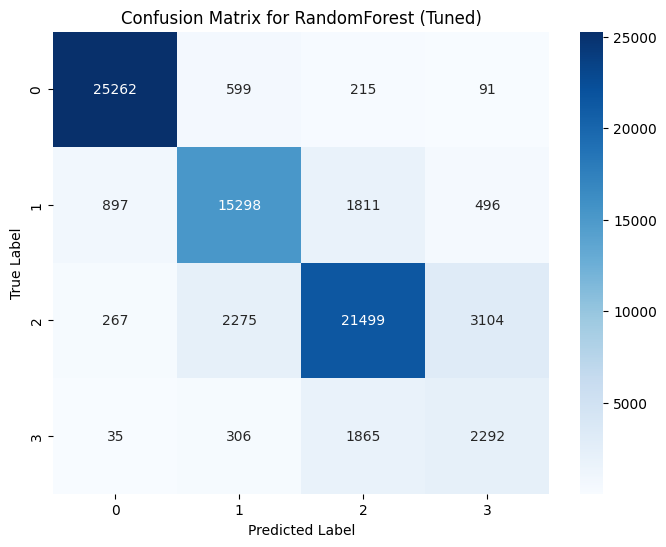


💾 5단계: 모델 저장
✅ RF 모델 저장 완료: model/rf_vol_model_0809.pkl


In [6]:
# ======================================================================
# 🚀 "Volume" 과제 최종 평가 파이프라인 (랜덤 포레스트 단일 모델)
# ======================================================================
print("✅ 라이브러리 로딩 시작...")
import joblib
import pandas as pd
import numpy as np
import time
import os
import warnings

# 모델 및 평가 관련 라이브러리
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
print("✅ 라이브러리 로딩 완료!")

# =======================================================
# ✅ 데이터 로딩 (사전 완료 가정)
# =======================================================
# 사용자의 요청에 따라, 아래 두 데이터는 이미 로딩되어 있다고 가정합니다.
# flow_data = joblib.load("task2_data/train_flow_data_cleaned.pkl")
# all_packets = joblib.load("task2_data/train_packet_data_cleaned.pkl")
# print(f"✅ 전체 Flow 데이터 ({len(flow_data):,}개) 사용")
# print(f"✅ 전체 Packet 데이터 ({len(all_packets):,}개) 사용")


# =======================================================
# 🔧 1단계: 특징 추출 함수 정의 (기존과 동일)
# =======================================================
print("\n" + "="*80)
print("🔧 1단계: 특징 추출 함수 정의")
print("="*80)

def extract_features_for_n_packets(packets, n):
    """
    주어진 'n'을 최대치로 하여, 실제 사용 가능한 패킷만으로 특징을 추출합니다.
    """
    num_packets_available = len(packets)
    if num_packets_available == 0: return {}

    n_to_use = min(n, num_packets_available)
    packets = packets.iloc[:n_to_use]
    
    features = {}
    for col in ['ip_len', 'ip_hdr_len', 'tcp_len', 'tcp_hdr_len']:
        if col in packets.columns:
            values = packets[col].values
            features[f'{col}_mean_{n}'] = np.mean(values)
            features[f'{col}_std_{n}'] = np.std(values) if len(values) > 1 else 0
            features[f'{col}_sum_{n}'] = np.sum(values)
    if 'packet_capture_time' in packets.columns and len(packets) > 1:
        try:
            times = pd.to_datetime(packets['packet_capture_time'])
            time_diffs = np.diff(times).astype('timedelta64[us]').astype(float)
            if len(time_diffs) > 0:
                features[f'inter_time_mean_{n}'] = np.mean(time_diffs)
                features[f'inter_time_std_{n}'] = np.std(time_diffs) if len(time_diffs) > 1 else 0
        except Exception: pass
    if 'tcp_window_size' in packets.columns:
        features[f'initial_tcp_win_size'] = packets['tcp_window_size'].iloc[0]
        features[f'mean_tcp_win_size_{n}'] = packets['tcp_window_size'].mean()
    flag_cols = ['tcp_flags_ack', 'tcp_flags_push', 'tcp_flags_reset', 'tcp_flags_syn', 'tcp_flags_fin']
    for flag in flag_cols:
        if flag in packets.columns:
            features[f'{flag}_count_{n}'] = packets[flag].sum()
    for col in ['ip_tos', 'ip_ttl']:
        if col in packets.columns:
            values = packets[col].values
            features[f'{col}_mean_{n}'] = np.mean(values)
            features[f'first_{col}'] = values[0]
    if 'ip_len' in packets.columns and 'tcp_len' in packets.columns:
        total_ip_len = packets['ip_len'].sum()
        total_tcp_len = packets['tcp_len'].sum()
        features[f'payload_ratio_{n}'] = total_tcp_len / total_ip_len if total_ip_len > 0 else 0
    return features
print("✅ 특징 추출 함수 준비 완료!")


# =======================================================
# 🔬 2단계: 최종 데이터 준비 (전체 데이터 사용)
# =======================================================
print("\n" + "="*80)
print("🔬 2단계: 최종 데이터 준비 (최대 N=3, 전체 데이터)")
print("="*80)

N_MAX = 3
print(f"🚀 최대 N={N_MAX} 값을 기준으로 전체 데이터에 대한 특징 추출 중...")
start_time = time.time()
features_list = []
successful_indices = []

# 전체 데이터 인덱스에 대해 특징 추출 실행
for i in range(len(flow_data)):
    try:
        packet_df = all_packets[i]
        if isinstance(packet_df, pd.DataFrame) and not packet_df.empty:
            features = extract_features_for_n_packets(packet_df, n=N_MAX)
            if features:
                features_list.append(features)
                successful_indices.append(i)
    except Exception:
        continue

X = pd.DataFrame(features_list).fillna(0)
y = flow_data.iloc[successful_indices]['volume_class']
print(f"✅ 특징 추출 완료! (소요 시간: {time.time() - start_time:.2f}초, 최종 샘플 수: {len(X):,}개)")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"📊 데이터 분할 완료: 학습 {len(X_train):,}개 | 검증 {len(X_test):,}개")

print("\n⏳ 클래스 가중치를 계산합니다...")
volume_classes = np.unique(y_train)
volume_weights_array = compute_class_weight(class_weight='balanced', classes=volume_classes, y=y_train)
volume_class_weights_dict = {int(cls): weight for cls, weight in zip(volume_classes, volume_weights_array)}
print(f"✅ 계산된 가중치(dict): {volume_class_weights_dict}")


# =======================================================
# 🏆 3단계: 랜덤 포레스트 모델 정의 및 학습
# =======================================================
print("\n" + "="*80)
print("🏆 3단계: 랜덤 포레스트 모델 정의 및 학습")
print("="*80)

champion_params_rf = {'n_estimators': 855, 'max_depth': 22}
print(f"사용될 하이퍼파라미터: {champion_params_rf}")

rf_volume = RandomForestClassifier(
    **champion_params_rf,
    class_weight=volume_class_weights_dict,
    random_state=42,
    n_jobs=-1
)

print("\n⏳ 모델 학습 시작...")
start_time = time.time()
rf_volume.fit(X_train, y_train)
end_time = time.time()
print(f"✅ 학습 완료! (소요 시간: {end_time - start_time:.2f}초)")


# =======================================================
# 📊 4단계: 최종 성능 평가
# =======================================================
print("\n" + "="*80)
print("📊 4단계: 최종 성능 평가")
print("="*80)

y_pred = rf_volume.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, zero_division=0))

print("\n--- 클래스별 F1-Score ---")
class_f1_scores = f1_score(y_test, y_pred, average=None, labels=volume_classes)
for cls, score in zip(volume_classes, class_f1_scores):
    print(f"Class {int(cls)} F1-Score: {score:.4f}")

print("\n--- Confusion Matrix ---")
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=rf_volume.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_volume.classes_, yticklabels=rf_volume.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RandomForest (Tuned)')
plt.show()


# =======================================================
# 💾 5단계: 모델 저장
# =======================================================
print("\n" + "="*80)
print("💾 5단계: 모델 저장")
print("="*80)

# 저장할 디렉토리 생성
if not os.path.exists('model'):
    os.makedirs('model')
    print("📂 'model' 디렉토리 생성 완료.")

# 모델 저장
model_path = 'model/rf_vol_model_0809.pkl'
joblib.dump(rf_volume, model_path)
print(f'✅ RF 모델 저장 완료: {model_path}')
